In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
from metpy.plots import SkewT

from sounding_utils import *
from importlib import reload

from functools import partial

import sys
sys.path.append('../../') # lets us import ptype package from the subdir

#import ptype.

from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster
import dask
import glob
from os.path import join

In [64]:
cluster = PBSCluster(#resource_spec='select=1:ncpus=2:mem=32GB',
                     project='NAML0001',
                     cores=2,
                     n_workers=8,
                     queue='casper',
                     walltime='01:00:00',
                     memory="50GB", #memory per worker
                     interface='ib0',
                     local_directory='/glade/work/dkimpara/pytpe/dask/',
                     log_directory="/glade/work/dkimpara/ptype/dask_logs/")

# Change your url to the dask dashboard so you can see it
# dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
print(f"Use this link to monitor the workload: {cluster.dashboard_link}")
                    
client = Client(cluster)
# cluster

/glade/work/dkimpara/conda-envs/ptype/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/dkimpara/conda-envs/ptype/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37015 instead
  warnings.warn(


Use this link to monitor the workload: https://jupyterhub.hpc.ucar.edu/stable/user/dkimpara/pux/proxy/37015/status


In [65]:
a = glob.glob("/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/0000/*.nc")
b = glob.glob("/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/0100/*.nc")
c = glob.glob("/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/0200/*.nc")

files = a + b + c

In [67]:
plot_func = partial(composites_multi_x, 
                    y_col='heightAboveGround',
                    x_cols = ['t_h', 'dpt_h'], 
                    markers=['o', '*'], 
                    plot_median=True
                    )

1min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


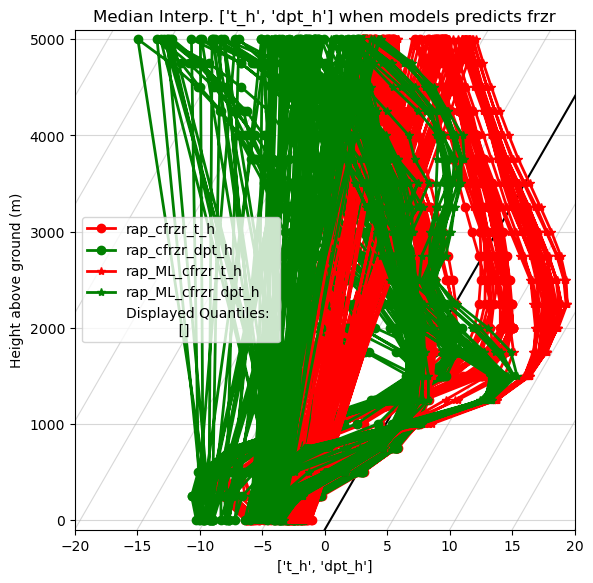

In [68]:
%%timeit -n 1 -r 1
rap = xr.open_mfdataset(files, 
                  concat_dim='heightAboveGround', 
                  combine='nested',
                  parallel=True,
                  engine='h5netcdf',
                  decode_cf=True).persist() #try netcdf #chunk by height above groundlevel

rap.attrs['nwp'] = 'rap'
#netcdf4 engine is faster

plot_func(ds=rap,cols=['cfrzr', 'ML_cfrzr'])

In [69]:
rap.chunks

Frozen({'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'heightAboveGround': (21,), 'y': (337,), 'x': (451,), 'isobaricInhPa': (37,)})

In [ ]:
%%timeit -n 1 -r 1
rap = xr.open_mfdataset(files, 
                  concat_dim='time', 
                  combine='nested',
                  chunks={'heightAboveGround':1},
                  parallel=True,
                  decode_cf=True).persist() #try netcdf #chunk by height above groundlevel

rap.attrs['nwp'] = 'rap'
plot_func(ds=rap,cols=['cfrzr', 'ML_cfrzr'])

In [ ]:
rap.chunks

In [ ]:
rap

In [63]:
client.shutdown()

/glade/work/dkimpara/conda-envs/ptype/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
2023-06-15 12:02:26,540 - distributed.batched - INFO - Batched Comm Closed <TCP (closed)  local=tcp://10.12.206.63:46217 remote=tcp://10.12.206.63:38916>
Traceback (most recent call last):
  File "/glade/work/dkimpara/conda-envs/ptype/lib/python3.10/site-packages/distributed/batched.py", line 115, in _background_send
    nbytes = yield coro
  File "/glade/work/dkimpara/conda-envs/ptype/lib/python3.10/site-packages/tornado/gen.py", line 767, in run
    value = future.result()
  File "/glade/work/dkimpara/conda-envs/ptype/lib/python3.10/sit

In [6]:
del rap

In [31]:
# create dewpoint from relative humidity since RAP doesn't natively carry dewpoint
rap['dpt'] = dewpoint_from_relative_humidity(rap['t'] * units.degC,
                                             rap['r'].values / 100)

**Recall our calibration plots:**

![alt text](soundings_files/MLCalibration.png "Calibration of ML model")

In [ ]:
plot_func = partial(quantile_composites_multi_x, 
                    ds=rap, 
                    y_col='heightAboveGround',
                    x_col = 't_h', 
                    markers=['o', '*'], 
                    colors=['b','g'],
                    plot_median=True
                    )

In [34]:
plot_func = partial(quantile_composites, 
                    ds=rap, 
                    y_col='heightAboveGround',
                    x_col = 't_h', 
                    markers=['o', '*'], 
                    colors=['b','g'],
                    plot_median=True
                    )

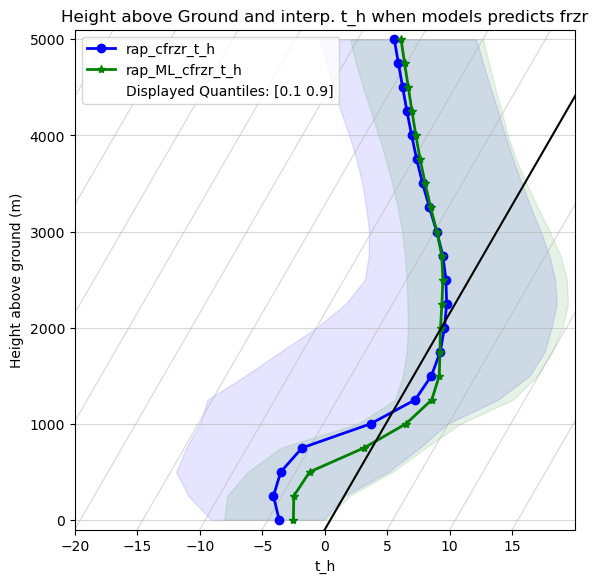

In [35]:
plot_func(cols=['cfrzr', 'ML_cfrzr'])

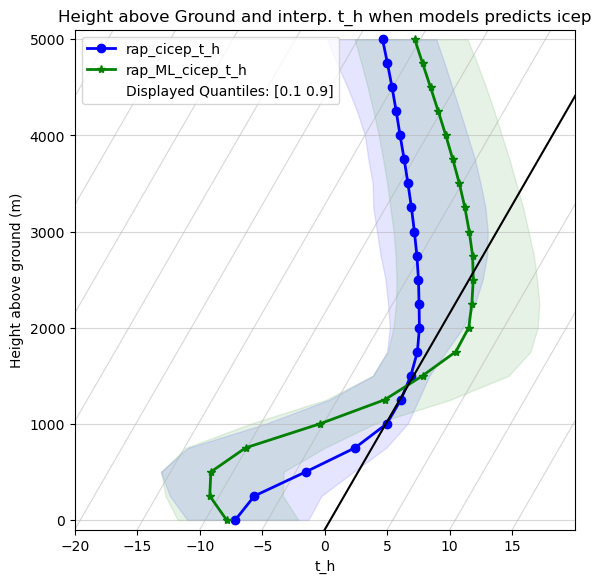

In [88]:
plot_func(cols=['cicep', 'ML_cicep'])

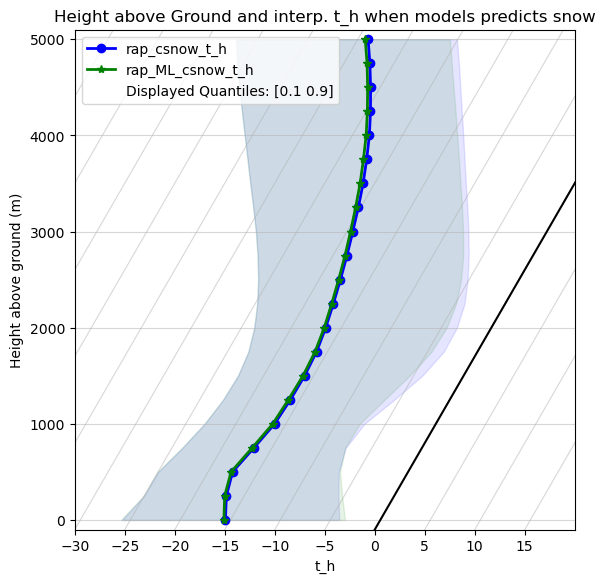

In [89]:
plot_func(cols = ['csnow', 'ML_csnow'],xlowlim=-30)

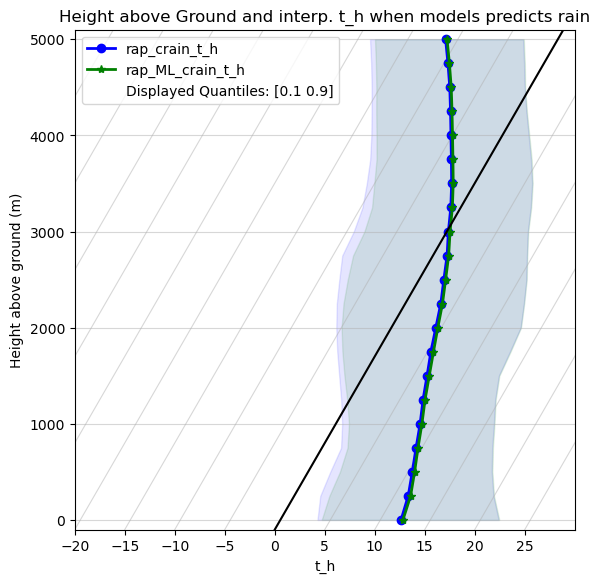

In [90]:
plot_func(cols =['crain', 'ML_crain'],xhighlim=30)

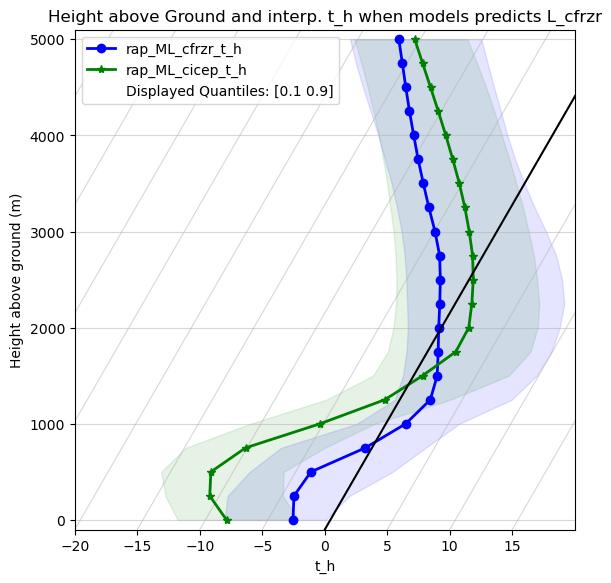

In [91]:
plot_func(cols = ['ML_cfrzr', 'ML_cicep'])


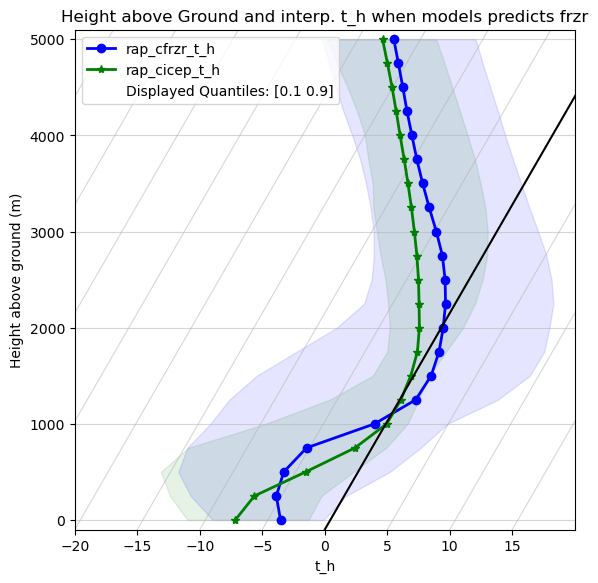

In [92]:
plot_func(cols = ['cfrzr', 'cicep'])
